## 1. Import Packages

In [1]:
import os
import cv2
import glob
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow.python.client import device_lib
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.applications import resnet50
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Flatten, Activation, BatchNormalization, LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.keras.models import load_model, Model
from sklearn.metrics import confusion_matrix, classification_report
from keras.utils import plot_model
from PIL import ImageFont, ImageDraw, Image
%matplotlib inline

## 2. GPU Available and Device Check

In [2]:
print(tf.config.list_physical_devices('GPU'))
print(device_lib.list_local_devices())

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3147573450131243191
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14648653952
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6090115075617783546
physical_device_desc: "device: 0, name: NVIDIA Tesla T4, pci bus id: 0001:00:00.0, compute capability: 7.5"
]


## 3. Dataset
  - DeepFashion (Category and Attribute Prediction Benchmark)
    - http://mmlab.ie.cuhk.edu.hk/projects/DeepFashion/AttributePrediction.html

In [3]:
# Deepfashion Dataset Path
orig_dataset_path = '/data/Deepfashion/prepare_dataset'
orig_train_path = orig_dataset_path + '/train'
orig_validation_path = orig_dataset_path + '/validation'
orig_test_path = orig_dataset_path + '/test'

## 4. Category Selection (Train, Validation, Test)
- Deepfashion Attribute and Prediction 원본 데이터 셋 카테고리
    - [('Dress', 52137), ('Tee', 26652), ('Blouse', 17751), ('Shorts', 14194), ('Tank', 11203), ('Skirt', 10793), ('Cardigan', 9605), ('Sweater', 9516), ('Jacket', 7547), ('Top', 7269), ('Romper', 5424), ('Blazer', 5407), ('Jeans', 5125), ('Jumpsuit', 4463), ('Leggings', 3570), ('Joggers', 3259), ('Sweatpants', 2223), ('Kimono', 1636), ('Coat', 1538), ('Cutoffs', 1176), ('Sweatshorts', 780), ('Poncho', 578), ('Jersey', 533), ('Henley', 520), ('Parka', 490), ('Jeggings', 442), ('Chinos', 373), ('Culottes', 358), ('Trunks', 286), ('Button-Down', 242), ('Bomber', 228), ('Flannel', 223), ('Anorak', 120), ('Robe', 106), ('Turtleneck', 98), ('Kaftan', 97), ('Peacoat', 62), ('Capris', 56), ('Onesie', 46), ('Caftan', 37), ('Gauchos', 34), ('Jodhpurs', 31), ('Sarong', 17), ('Coverup', 12), ('Halter', 10)]
- 삭제할 카테고리
    - Halter, Coverup, Sarong, Jodhpurs, Gauchos, Caftan, Onesie, Capris, Kaftan, Turtleneck, Robe, Culottes, Jersey, Poncho, Kimono, Tank, Top, Trunks
- 카테고리 통합
    - Shirt = Button-Down + Flannel
    - Sweatpants = Sweatpants + Sweatshorts
    - Jumpsuit-Romper = Jumpsuit + Romper
    - Jeans = Jeans + Jeggings
    - Blouse-Shirts = Blouse + Shirts
- 카테고리 삭제 및 통합 후
    - ['Blazer', 'Blouse-Shirts', 'Cardigan', 'Coat', 'Cottonpants', 'Cutoffs', 'Dress', 'Hoodie', 'Jacket', 'Jeans', 'Joggers', 'Jumpsuit-Romper', 'Leggings', 'Parka', 'Shorts', 'Skirt', 'Sweater', 'Sweatpants', 'Tee']

In [4]:
# Data Load

# Train
orig_train = ImageDataGenerator(
    rescale=1./255
)

orig_train_dataset = orig_train.flow_from_directory(
    orig_train_path,
    target_size=(224, 224),
    class_mode='categorical',
    shuffle=False
)

# Validation
orig_validation = ImageDataGenerator(
    rescale=1./255
)

orig_validation_dataset = orig_validation.flow_from_directory(
    orig_validation_path,
    target_size=(224, 224),
    class_mode='categorical',
    shuffle=False
)

# Test
orig_test = ImageDataGenerator(
    rescale=1./255
)

orig_test_dataset = orig_test.flow_from_directory(
    orig_test_path,
    target_size=(224, 224),
    class_mode='categorical',
    shuffle=False
)

Found 186275 images belonging to 19 classes.
Found 35663 images belonging to 19 classes.
Found 35475 images belonging to 19 classes.


In [5]:
X_train, y_train = next(orig_train_dataset)

print(X_train.shape)
print(y_train.shape)

X_val, y_val = next(orig_validation_dataset)

print(X_val.shape)
print(y_val.shape)

X_test, y_test = next(orig_test_dataset)

print(X_test.shape)
print(y_test.shape)

(32, 224, 224, 3)
(32, 19)
(32, 224, 224, 3)
(32, 19)
(32, 224, 224, 3)
(32, 19)


## 5. Train Origin Dataset Visualization

Class indices of orig train dataset:  {'Blazer': 0, 'Blouse-Shirts': 1, 'Cardigan': 2, 'Coat': 3, 'Cottonpants': 4, 'Cutoffs': 5, 'Dress': 6, 'Hoodie': 7, 'Jacket': 8, 'Jeans': 9, 'Joggers': 10, 'Jumpsuit-Romper': 11, 'Leggings': 12, 'Parka': 13, 'Shorts': 14, 'Skirt': 15, 'Sweater': 16, 'Sweatpants': 17, 'Tee': 18}

dict_keys(['Blazer', 'Blouse-Shirts', 'Cardigan', 'Coat', 'Cottonpants', 'Cutoffs', 'Dress', 'Hoodie', 'Jacket', 'Jeans', 'Joggers', 'Jumpsuit-Romper', 'Leggings', 'Parka', 'Shorts', 'Skirt', 'Sweater', 'Sweatpants', 'Tee'])

Sorted category nums of orig train dataset:  [('Dress', 52137), ('Tee', 26652), ('Blouse-Shirts', 18218), ('Shorts', 14194), ('Skirt', 10793), ('Jumpsuit-Romper', 9888), ('Cardigan', 9605), ('Sweater', 9516), ('Jacket', 7776), ('Jeans', 5568), ('Blazer', 5407), ('Leggings', 3570), ('Joggers', 3259), ('Sweatpants', 3004), ('Hoodie', 2909), ('Coat', 1601), ('Cutoffs', 1176), ('Parka', 610), ('Cottonpants', 373)]

Total train dataset nums:  186256



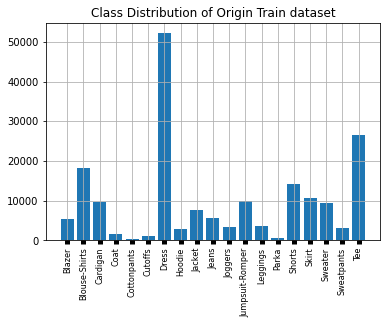

In [6]:
orig_train_dataset_class_indices = orig_train_dataset.class_indices
print('Class indices of orig train dataset: ', orig_train_dataset_class_indices)
print()
print(orig_train_dataset_class_indices.keys())

orig_train_category_nums = {}

for filename in orig_train_dataset.filenames:
    train_class_name = filename.split('/')[0]
    if train_class_name not in orig_train_category_nums:
        orig_train_category_nums[train_class_name] = 0
    else:
        orig_train_category_nums[train_class_name] += 1

print()
print("Sorted category nums of orig train dataset: ", sorted(orig_train_category_nums.items(), key=lambda x: x[1], reverse=True))
print()
print("Total train dataset nums: ", sum(orig_train_category_nums.values()))
print()
fig, ax = plt.subplots()
plt.bar(list(orig_train_category_nums.keys()), orig_train_category_nums.values())
plt.title("Class Distribution of Origin Train dataset")
plt.xticks(rotation=90)
plt.tick_params(axis='x', width=5, labelsize=8)
plt.grid(True)
plt.show()

## 6. Train Dataset Over/Under-sampling and Visualization

In [7]:
# # Train data sampling
# train_class_names = ['Blazer', 'Blouse-Shirts', 'Cardigan', 'Coat', 'Cottonpants', 'Cutoffs', 'Dress', 'Hoodie', 'Jacket', 'Jeans', 'Joggers', 'Jumpsuit-Romper', 'Leggings', 'Parka', 'Shorts', 'Skirt', 'Sweater', 'Sweatpants', 'Tee']
# print(len(train_class_names))

# train_paths = []

# for cls in train_class_names:
#     for f in glob.glob(orig_train_path + '/' + cls + '/*.jpg'):
#         # Undersampling (~10000)
#         if cls == 'Dress' or cls == 'Tee' or cls == 'Blouse-Shirts' or cls == 'Shorts':
#             train_paths.append(f)
#         # 원본 데이터 개수 유지
#         elif cls == 'Skirt' or cls == 'Jumpsuit-Romper' or cls == 'Cardigan' or cls == 'Sweater':
#             train_paths.append(f)
#         # Oversampling 후 10000개로 축소
#         elif cls == 'Jacket':
#             for i in range(2):
#                 train_paths.append(f)
#         # Oversampling
#         elif cls == 'Jeans' or cls == 'Blazer':
#             for i in range(2):
#                 train_paths.append(f)
#         elif cls == 'Leggings'or cls == 'Joggers' or cls == 'Sweatpants' or cls == 'Hoodie':
#             for i in range(3):
#                 train_paths.append(f)
#         elif cls == 'Coat':
#             for i in range(6):
#                 train_paths.append(f)
#         elif cls == 'Cutoffs':
#             for i in range(8):
#                 train_paths.append(f)
#         elif cls == 'Parka':
#             for i in range(16):
#                 train_paths.append(f)
#         elif cls == 'Cottonpants':
#             for i in range(27):
#                 train_paths.append(f)

# print(train_paths[0])
# print(len(train_paths))

# train_paths_class = []

# for cls in train_class_names:
#     for f in glob.glob(orig_train_path + '/' + cls + '/*.jpg'):
#         # Undersampling (~10000)
#         if cls == 'Dress' or cls == 'Tee' or cls == 'Blouse-Shirts' or cls == 'Shorts':
#             train_paths_class.append(f.split('/')[5])
#         # 원본 데이터 개수 유지
#         elif cls == 'Skirt' or cls == 'Jumpsuit-Romper' or cls == 'Cardigan' or cls == 'Sweater':
#             train_paths_class.append(f.split('/')[5])
#         # Oversampling 후 10000개로 축소
#         elif cls == 'Jacket':
#             for i in range(2):
#                 train_paths_class.append(f.split('/')[5])
#         # Oversampling
#         elif cls == 'Jeans' or cls == 'Blazer':
#             for i in range(2):
#                 train_paths_class.append(f.split('/')[5])
#         elif cls == 'Leggings'or cls == 'Joggers' or cls == 'Sweatpants' or cls == 'Hoodie':
#             for i in range(3):
#                 train_paths_class.append(f.split('/')[5])
#         elif cls == 'Coat':
#             for i in range(6):
#                 train_paths_class.append(f.split('/')[5])
#         elif cls == 'Cutoffs':
#             for i in range(8):
#                 train_paths_class.append(f.split('/')[5])
#         elif cls == 'Parka':
#             for i in range(16):
#                 train_paths_class.append(f.split('/')[5])
#         elif cls == 'Cottonpants':
#             for i in range(27):
#                 train_paths_class.append(f.split('/')[5])

# print(train_paths_class[0])
# print(len(train_paths_class))

# train_df = {'filepath': train_paths, 'class_name': train_paths_class}
# df_train = pd.DataFrame(train_df)
# print(df_train)

# train_csv_path = '/home/azure/passion/AI/Final/sampling_dataframe/finaltrain.csv'
# df_train.to_csv(train_csv_path)

In [8]:
train_csv_path = '/home/azure/passion/AI/Final/sampling_dataframe/finaltrain.csv'
train_df = pd.read_csv(train_csv_path)
train_df.head()

,Unnamed: 0,filepath,class_name
0,0,/data/Deepfashion/prepare_dataset/train/Blazer...,Blazer
1,1,/data/Deepfashion/prepare_dataset/train/Blazer...,Blazer
2,2,/data/Deepfashion/prepare_dataset/train/Blazer...,Blazer
3,3,/data/Deepfashion/prepare_dataset/train/Blazer...,Blazer
4,4,/data/Deepfashion/prepare_dataset/train/Blazer...,Blazer


In [9]:
train_datagen = ImageDataGenerator(
    rescale=1./255
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filepath',
    y_col='class_name',
    target_size=(224, 224),
    batch_size=64
)

Found 201400 validated image filenames belonging to 19 classes.


In [10]:
train_category_nums = {}

print(train_generator.filenames[0].split('/')[5])

for filename in train_generator.filenames:
    class_name = filename.split('/')[5]
    if class_name not in train_category_nums:
        train_category_nums[class_name] = 0
    else:
        train_category_nums[class_name] += 1

print(sorted(train_category_nums.items(), key=lambda x: x[1], reverse=True))
print(sum(train_category_nums.values()))

Blazer
[('Blouse-Shirts', 12499), ('Dress', 12499), ('Jacket', 12499), ('Shorts', 12499), ('Tee', 12499), ('Jeans', 11137), ('Blazer', 10815), ('Skirt', 10793), ('Leggings', 10712), ('Cottonpants', 10097), ('Jumpsuit-Romper', 9888), ('Joggers', 9779), ('Parka', 9775), ('Coat', 9611), ('Cardigan', 9605), ('Sweater', 9516), ('Cutoffs', 9415), ('Sweatpants', 9014), ('Hoodie', 8729)]
201381


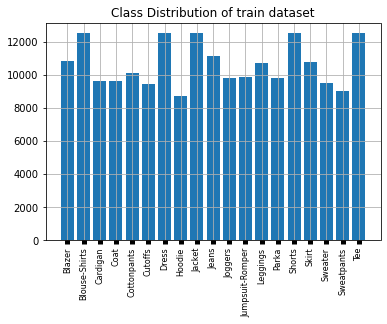

In [11]:
fig, ax = plt.subplots()
plt.bar(list(train_category_nums.keys()), train_category_nums.values())
plt.title("Class Distribution of train dataset")
plt.xticks(rotation=90)
plt.tick_params(axis='x', width=5, labelsize=8)
plt.grid(True)
plt.show()

## 7. Validation Origin Dataset Visualization

Class indices of orig validation dataset:  {'Blazer': 0, 'Blouse-Shirts': 1, 'Cardigan': 2, 'Coat': 3, 'Cottonpants': 4, 'Cutoffs': 5, 'Dress': 6, 'Hoodie': 7, 'Jacket': 8, 'Jeans': 9, 'Joggers': 10, 'Jumpsuit-Romper': 11, 'Leggings': 12, 'Parka': 13, 'Shorts': 14, 'Skirt': 15, 'Sweater': 16, 'Sweatpants': 17, 'Tee': 18}

Sorted category nums of orig validation dataset:  [('Dress', 10051), ('Tee', 5142), ('Blouse-Shirts', 3478), ('Shorts', 2699), ('Skirt', 2045), ('Jumpsuit-Romper', 1828), ('Cardigan', 1827), ('Sweater', 1821), ('Jacket', 1513), ('Jeans', 1051), ('Blazer', 1039), ('Leggings', 717), ('Joggers', 580), ('Sweatpants', 580), ('Hoodie', 540), ('Coat', 293), ('Cutoffs', 248), ('Parka', 113), ('Cottonpants', 79)]

Total validation dataset nums:  35644



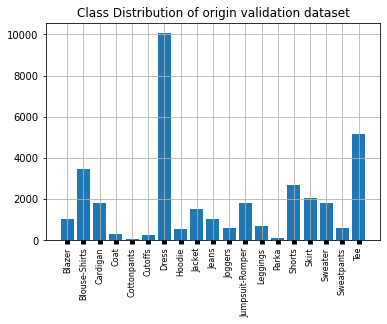

In [12]:
orig_validation_dataset_class_indices = orig_validation_dataset.class_indices
print('Class indices of orig validation dataset: ', orig_validation_dataset_class_indices)

orig_validation_category_nums = {}

for filename in orig_validation_dataset.filenames:
    validation_class_name = filename.split('/')[0]
    if validation_class_name not in orig_validation_category_nums:
        orig_validation_category_nums[validation_class_name] = 0
    else:
        orig_validation_category_nums[validation_class_name] += 1

print()
print("Sorted category nums of orig validation dataset: ", sorted(orig_validation_category_nums.items(), key=lambda x: x[1], reverse=True))
print()
print("Total validation dataset nums: ", sum(orig_validation_category_nums.values()))
print()
fig, ax = plt.subplots()
plt.bar(list(orig_validation_category_nums.keys()), orig_validation_category_nums.values())
plt.title("Class Distribution of origin validation dataset")
plt.xticks(rotation=90)
plt.tick_params(axis='x', width=5, labelsize=8)
plt.grid(True)
plt.show()

In [13]:
# # validation data sampling
# validation_class_names = ['Blazer', 'Blouse-Shirts', 'Cardigan', 'Coat', 'Cottonpants', 'Cutoffs', 'Dress', 'Hoodie', 'Jacket', 'Jeans', 'Joggers', 'Jumpsuit-Romper', 'Leggings', 'Parka', 'Shorts', 'Skirt', 'Sweater', 'Sweatpants', 'Tee']
# print(len(validation_class_names))

# validation_paths = []

# for cls in validation_class_names:
#     for f in glob.glob(orig_validation_path + '/' + cls + '/*.jpg'):
#         validation_paths.append(f)

# print(validation_paths[0])
# print(len(validation_paths))

# validation_paths_class = []

# for cls in validation_class_names:
#     for f in glob.glob(orig_validation_path + '/' + cls + '/*.jpg'):
#         validation_paths_class.append(f.split('/')[5])

# print(validation_paths_class[0])
# print(len(validation_paths_class))

# validation_df = {'filepath': validation_paths, 'class_name': validation_paths_class}
# df_validation = pd.DataFrame(validation_df)
# print(df_validation)

# validation_csv_path = '/home/azure/passion/AI/Final/sampling_dataframe/finalvalidation.csv'
# df_validation.to_csv(validation_csv_path)

In [14]:
validation_csv_path = '/home/azure/passion/AI/Final/sampling_dataframe/finalvalidation.csv'
validation_df = pd.read_csv(validation_csv_path)
validation_df.head()

,Unnamed: 0,filepath,class_name
0,0,/data/Deepfashion/prepare_dataset/validation/B...,Blazer
1,1,/data/Deepfashion/prepare_dataset/validation/B...,Blazer
2,2,/data/Deepfashion/prepare_dataset/validation/B...,Blazer
3,3,/data/Deepfashion/prepare_dataset/validation/B...,Blazer
4,4,/data/Deepfashion/prepare_dataset/validation/B...,Blazer


In [15]:
validation_datagen = ImageDataGenerator(
    rescale=1./255
)

validation_generator = validation_datagen.flow_from_dataframe(
    validation_df,
    x_col='filepath',
    y_col='class_name',
    target_size=(224, 224),
    batch_size=64,
    shuffle=False
)

Found 35663 validated image filenames belonging to 19 classes.


In [16]:
validation_category_nums = {}

print(validation_generator.filenames[0].split('/')[5])

for filename in validation_generator.filenames:
    class_name = filename.split('/')[5]
    if class_name not in validation_category_nums:
        validation_category_nums[class_name] = 0
    else:
        validation_category_nums[class_name] += 1

print(sorted(validation_category_nums.items(), key=lambda x: x[1], reverse=True))
print(sum(validation_category_nums.values()))

Blazer
[('Dress', 10051), ('Tee', 5142), ('Blouse-Shirts', 3478), ('Shorts', 2699), ('Skirt', 2045), ('Jumpsuit-Romper', 1828), ('Cardigan', 1827), ('Sweater', 1821), ('Jacket', 1513), ('Jeans', 1051), ('Blazer', 1039), ('Leggings', 717), ('Joggers', 580), ('Sweatpants', 580), ('Hoodie', 540), ('Coat', 293), ('Cutoffs', 248), ('Parka', 113), ('Cottonpants', 79)]
35644


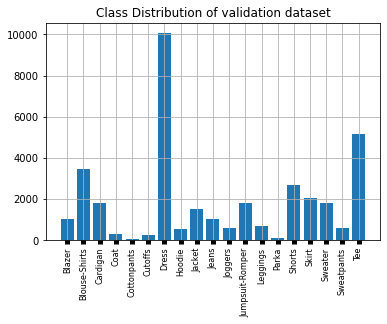

In [17]:
fig, ax = plt.subplots()
plt.bar(list(validation_category_nums.keys()), validation_category_nums.values())
plt.title("Class Distribution of validation dataset")
plt.xticks(rotation=90)
plt.tick_params(axis='x', width=5, labelsize=8)
plt.grid(True)
plt.show()

## 8. Test Origin Dataset Visualization

Class indices of orig test dataset:  {'Blazer': 0, 'Blouse-Shirts': 1, 'Cardigan': 2, 'Coat': 3, 'Cottonpants': 4, 'Cutoffs': 5, 'Dress': 6, 'Hoodie': 7, 'Jacket': 8, 'Jeans': 9, 'Joggers': 10, 'Jumpsuit-Romper': 11, 'Leggings': 12, 'Parka': 13, 'Shorts': 14, 'Skirt': 15, 'Sweater': 16, 'Sweatpants': 17, 'Tee': 18}

Sorted category nums of orig test dataset:  [('Dress', 9967), ('Tee', 5090), ('Blouse-Shirts', 3415), ('Shorts', 2770), ('Skirt', 1932), ('Cardigan', 1876), ('Jumpsuit-Romper', 1842), ('Sweater', 1783), ('Jacket', 1484), ('Jeans', 1048), ('Blazer', 1046), ('Leggings', 723), ('Hoodie', 596), ('Joggers', 574), ('Sweatpants', 567), ('Coat', 320), ('Cutoffs', 242), ('Parka', 109), ('Cottonpants', 72)]

Total test dataset nums:  35456



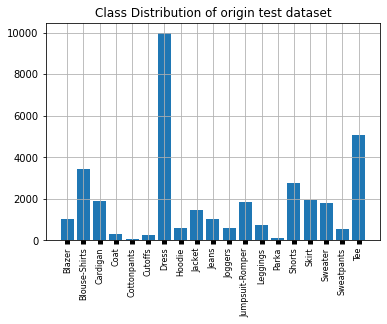

In [18]:
orig_test_dataset_class_indices = orig_test_dataset.class_indices
print('Class indices of orig test dataset: ', orig_test_dataset_class_indices)

orig_test_category_nums = {}

for filename in orig_test_dataset.filenames:
    test_class_name = filename.split('/')[0]
    if test_class_name not in orig_test_category_nums:
        orig_test_category_nums[test_class_name] = 0
    else:
        orig_test_category_nums[test_class_name] += 1

print()
print("Sorted category nums of orig test dataset: ", sorted(orig_test_category_nums.items(), key=lambda x: x[1], reverse=True))
print()
print("Total test dataset nums: ", sum(orig_test_category_nums.values()))
print()
fig, ax = plt.subplots()
plt.bar(list(orig_test_category_nums.keys()), orig_test_category_nums.values())
plt.title("Class Distribution of origin test dataset")
plt.xticks(rotation=90)
plt.tick_params(axis='x', width=5, labelsize=8)
plt.grid(True)
plt.show()

In [19]:
# # test data sampling
# test_class_names = ['Blazer', 'Blouse-Shirts', 'Cardigan', 'Coat', 'Cottonpants', 'Cutoffs', 'Dress', 'Hoodie', 'Jacket', 'Jeans', 'Joggers', 'Jumpsuit-Romper', 'Leggings', 'Parka', 'Shorts', 'Skirt', 'Sweater', 'Sweatpants', 'Tee']
# print(len(test_class_names))

# test_paths = []

# for cls in test_class_names:
#     for f in glob.glob(orig_test_path + '/' + cls + '/*.jpg'):
#         test_paths.append(f)
# print(test_paths[0])
# print(len(test_paths))

# test_paths_class = []

# for cls in test_class_names:
#     for f in glob.glob(orig_test_path + '/' + cls + '/*.jpg'):
#         test_paths_class.append(f.split('/')[5])

# print(test_paths_class[0])
# print(len(test_paths_class))

# test_df = {'filepath': test_paths, 'class_name': test_paths_class}
# df_test = pd.DataFrame(test_df)
# print(df_test)

# test_csv_path = '/home/azure/passion/AI/Final/sampling_dataframe/finaltest.csv'
# df_test.to_csv(test_csv_path)

In [20]:
test_csv_path = '/home/azure/passion/AI/Final/sampling_dataframe/finaltest.csv'
test_df = pd.read_csv(test_csv_path)
test_df.head()

,Unnamed: 0,filepath,class_name
0,0,/data/Deepfashion/prepare_dataset/test/Blazer/...,Blazer
1,1,/data/Deepfashion/prepare_dataset/test/Blazer/...,Blazer
2,2,/data/Deepfashion/prepare_dataset/test/Blazer/...,Blazer
3,3,/data/Deepfashion/prepare_dataset/test/Blazer/...,Blazer
4,4,/data/Deepfashion/prepare_dataset/test/Blazer/...,Blazer


In [21]:
test_datagen = ImageDataGenerator(
    rescale=1./255
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='filepath',
    y_col='class_name',
    target_size=(224, 224),
    batch_size=64,
    shuffle=False
)

Found 35475 validated image filenames belonging to 19 classes.


In [22]:
test_category_nums = {}

print(test_generator.filenames[0].split('/')[5])

for filename in test_generator.filenames:
    class_name = filename.split('/')[5]
    if class_name not in test_category_nums:
        test_category_nums[class_name] = 0
    else:
        test_category_nums[class_name] += 1

print(sorted(test_category_nums.items(), key=lambda x: x[1], reverse=True))
print(sum(test_category_nums.values()))

Blazer
[('Dress', 9967), ('Tee', 5090), ('Blouse-Shirts', 3415), ('Shorts', 2770), ('Skirt', 1932), ('Cardigan', 1876), ('Jumpsuit-Romper', 1842), ('Sweater', 1783), ('Jacket', 1484), ('Jeans', 1048), ('Blazer', 1046), ('Leggings', 723), ('Hoodie', 596), ('Joggers', 574), ('Sweatpants', 567), ('Coat', 320), ('Cutoffs', 242), ('Parka', 109), ('Cottonpants', 72)]
35456


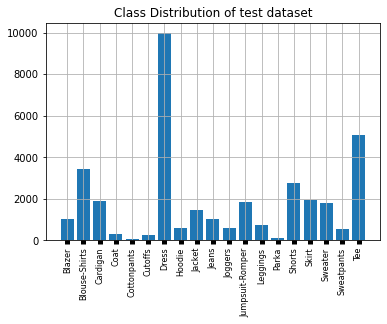

In [23]:
fig, ax = plt.subplots()
plt.bar(list(test_category_nums.keys()), test_category_nums.values())
plt.title("Class Distribution of test dataset")
plt.xticks(rotation=90)
plt.tick_params(axis='x', width=5, labelsize=8)
plt.grid(True)
plt.show()

## 9. Summary

In [24]:
train_class_labels_sampling = list(train_generator.class_indices.keys())
validation_class_labels_sampling = list(validation_generator.class_indices.keys())
test_class_labels_sampling = list(test_generator.class_indices.keys())
print('Sampling train class labels: \n', train_class_labels_sampling)
print('The number of train class labels: ', len(train_class_labels_sampling))
print('The number of train images sampling: ', len(train_generator.filenames))
print()
print('Sampling validation class labels: \n', validation_class_labels_sampling)
print('The number of validation class labels: ', len(validation_class_labels_sampling))
print('The number of validation images sampling: ', len(validation_generator.filenames))
print()
print('Sampling test class labels: \n', test_class_labels_sampling)
print('The number of test class labels: ', len(test_class_labels_sampling))
print('The number of test images sampling: ', len(test_generator.filenames))
print()


Sampling train class labels: 
 ['Blazer', 'Blouse-Shirts', 'Cardigan', 'Coat', 'Cottonpants', 'Cutoffs', 'Dress', 'Hoodie', 'Jacket', 'Jeans', 'Joggers', 'Jumpsuit-Romper', 'Leggings', 'Parka', 'Shorts', 'Skirt', 'Sweater', 'Sweatpants', 'Tee']
The number of train class labels:  19
The number of train images sampling:  201400

Sampling validation class labels: 
 ['Blazer', 'Blouse-Shirts', 'Cardigan', 'Coat', 'Cottonpants', 'Cutoffs', 'Dress', 'Hoodie', 'Jacket', 'Jeans', 'Joggers', 'Jumpsuit-Romper', 'Leggings', 'Parka', 'Shorts', 'Skirt', 'Sweater', 'Sweatpants', 'Tee']
The number of validation class labels:  19
The number of validation images sampling:  35663

Sampling test class labels: 
 ['Blazer', 'Blouse-Shirts', 'Cardigan', 'Coat', 'Cottonpants', 'Cutoffs', 'Dress', 'Hoodie', 'Jacket', 'Jeans', 'Joggers', 'Jumpsuit-Romper', 'Leggings', 'Parka', 'Shorts', 'Skirt', 'Sweater', 'Sweatpants', 'Tee']
The number of test class labels:  19
The number of test images sampling:  35475



## 10. ResNet50 Model Building

In [25]:
# Initialize the Resnet50 model
resnet50_conv = ResNet50(
    weights='imagenet',
    input_shape=(224, 224, 3),
    include_top=False,
    pooling='avg'
)

for layer in resnet50_conv.layers[:]:
    layer.trainable=True

# Check the trainable status of the individual layers
for layer in resnet50_conv.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f20c878b198> True
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7f20c86e57f0> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f20c86e5978> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f20c86b1c88> True
<tensorflow.python.keras.layers.core.Activation object at 0x7f20c8658ef0> True
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7f20c860c7b8> True
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f20c860cfd0> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f20c8619b70> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f20c8629128> True
<tensorflow.python.keras.layers.core.Activation object at 0x7f20c862e4a8> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f20c862ec88> True
<tensorflow.python.keras.layers.normaliz

In [26]:
# ResNet50
x = resnet50_conv.output
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.001))(x)
y = Dense(19, activation='softmax')(x)

model = Model(
    inputs=resnet50_conv.input,
    outputs=[y]
)

In [27]:
# Model Summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

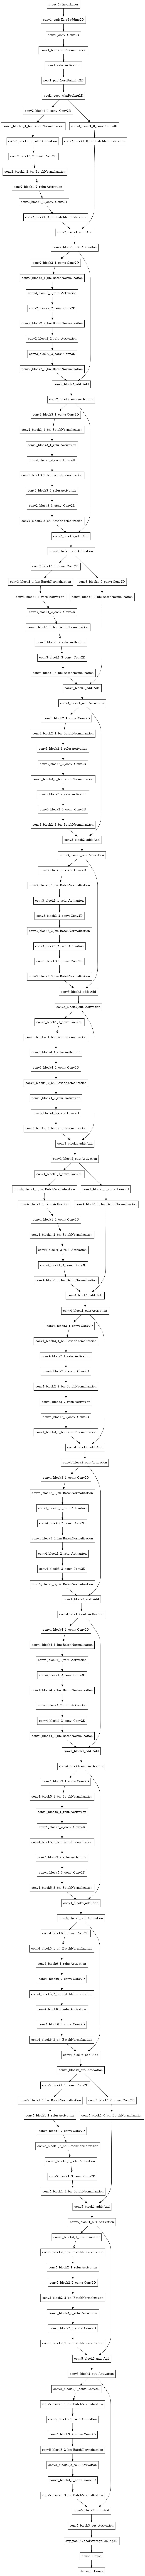

In [32]:
# Show a summary of the model
plot_model(model, to_file='/home/azure/passion/AI/Final/output/model_summary/final.jpg')

In [28]:
# Compile Model
model.compile(
    optimizer=SGD(lr=0.0001, momentum=0.9, nesterov=True),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.TopKCategoricalAccuracy(k=3, name='top_3_categorical_accuracy'),
        tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='top_5_categorical_accuracy')
    ]
)

## 11. Plotting Accuracy & Loss Curves

In [34]:
def curves(model_histories, epochs):

    acc = model_histories.history['accuracy']
    top_3_categorical_accuracy = model_histories.history['top_3_categorical_accuracy']
    top_5_categorical_accuracy = model_histories.history['top_5_categorical_accuracy']
    val_acc = model_histories.history['val_accuracy']
    val_top_3_categorical_accuracy = model_histories.history['val_top_3_categorical_accuracy']
    val_top_5_categorical_accuracy = model_histories.history['val_top_5_categorical_accuracy']
    loss = model_histories.history['loss']
    val_loss = model_histories.history['val_loss']

    # Plot
    plt.plot(range(epochs), acc, 'mo', label='Training accuracy')
    plt.plot(range(epochs), val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.savefig('/home/azure/passion/AI/Final/output/plot/final_accuracy.jpg')

    plt.figure()
    plt.plot(range(epochs), loss, 'mo', label='Training loss')
    plt.plot(range(epochs), val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.savefig('/home/azure/passion/AI/Final/output/plot/final_loss.jpg')
    
    plt.figure()
    plt.plot(range(epochs), top_3_categorical_accuracy, 'mo', label='Training top 3 categorical accuracy')
    plt.plot(range(epochs), val_top_3_categorical_accuracy, 'b', label='Validation top 3 categorical accuracy')
    plt.title('Training and validation top 3 catagorical accuracy')
    plt.legend()
    plt.savefig('/home/azure/passion/AI/Final/output/plot/final_top_3_accuracy.jpg')
    
    plt.figure()
    plt.plot(range(epochs), top_5_categorical_accuracy, 'mo', label='Training top 5 categorical accuracy')
    plt.plot(range(epochs), val_top_5_categorical_accuracy, 'b', label='Validation top 5 categorical accuracy')
    plt.title('Training and validation top 5 catagorical accuracy')
    plt.legend()
    plt.savefig('/home/azure/passion/AI/Final/output/plot/final_top_5_accuracy.jpg')
    plt.show()

## 12. Register Callbacks

In [35]:
def callback():
    
    # CSVLogger
    filename = '/home/azure/passion/AI/Final/output/csv_logger/final.csv'
    csv_log = tf.keras.callbacks.CSVLogger(
        filename, 
        separator=' ', 
        append=False
    )
    
    # EarlyStopping
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        patience=300, 
        verbose=1, 
        mode='min'
    )
    
    # ReduceLRonPlateau
    lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        patience=20,
        factor=0.5,
        verbose=1
    )
    
    # ModelCheckpoint
    check_point = tf.keras.callbacks.ModelCheckpoint(
        filepath='/home/azure/passion/AI/Final/output/checkpoint/final.ckpt',
        save_best_only=True, save_weights_only=True, monitor='val_loss'
    )
    
    callback_list = [csv_log, early_stopping, lr_reducer, check_point]
    return callback_list

In [36]:
callback_list = callback()

## 13. Fine-tune the model - Training

In [39]:
def fit_model(model, train_generator, validation_generator):
    
    history = model.fit(
        train_generator,
        epochs=10,
        steps_per_epoch=len(train_generator.filenames)//64,
        validation_data=validation_generator,
        workers=0,
        verbose=1,
        callbacks=callback_list
    )

    score = model.evaluate(
        validation_generator,
        verbose=1
    )

    return model, history, score

In [40]:
model, history, score = fit_model(model, train_generator, validation_generator)

# Learning curves
curves(history, epochs)
print('Validation Accuracy:{} \nValidation Loss:{}'.format(score[1] ,score[0]))
print('Validation Top 3 Accuracy: ', score[2])
print('Validation Top 5 Accuracy: ', score[3])
print(score)
# Model Save
model.save('/home/azure/passion/AI/Final/output/saved_model/final.h5')

Epoch 1/10
3146/3146 [==============================] - 2846s 899ms/step - loss: 2.5580 - accuracy: 0.6030 - top_3_categorical_accuracy: 0.8342 - top_5_categorical_accuracy: 0.9071 - val_loss: 2.0302 - val_accuracy: 0.7340 - val_top_3_categorical_accuracy: 0.9293 - val_top_5_categorical_accuracy: 0.9743
Epoch 2/10
3146/3146 [==============================] - 2768s 880ms/step - loss: 1.6622 - accuracy: 0.8438 - top_3_categorical_accuracy: 0.9661 - top_5_categorical_accuracy: 0.9902 - val_loss: 1.9223 - val_accuracy: 0.7440 - val_top_3_categorical_accuracy: 0.9241 - val_top_5_categorical_accuracy: 0.9697
Epoch 3/10
3146/3146 [==============================] - 2657s 845ms/step - loss: 1.3037 - accuracy: 0.9161 - top_3_categorical_accuracy: 0.9874 - top_5_categorical_accuracy: 0.9973 - val_loss: 1.8860 - val_accuracy: 0.7456 - val_top_3_categorical_accuracy: 0.9258 - val_top_5_categorical_accuracy: 0.9703
Epoch 4/10
3146/3146 [==============================] - 2656s 844ms/step - loss: 1.06

NameError: name 'epochs' is not defined

## 14. Evaluation

In [55]:
model = tf.keras.models.load_model('/home/azure/passion/AI/Final/output/saved_model/final.h5')
evaluation = model.evaluate(test_generator)
print('Test Loss: ', evaluation[0])
print('Test Accuracy: ', evaluation[1])
print('Test Top 3 Accuracy: ', evaluation[2])
print('Test Top 5 Accuracy: ', evaluation[3])

555/555 [==============================] - 109s 194ms/step - loss: 1.9409 - accuracy: 0.7425 - top_3_categorical_accuracy: 0.9202 - top_5_categorical_accuracy: 0.9642
Test Loss:  1.9408642053604126
Test Accuracy:  0.7425228953361511
Test Top 3 Accuracy:  0.9201691150665283
Test Top 5 Accuracy:  0.9641719460487366


## 15. Confusion Matrix & Classification Report

In [56]:
Y_pred = model.predict(test_generator)
Y_pred_argmax = np.argmax(Y_pred, axis=1)
Y_pred_list = Y_pred_argmax.tolist()
print(Y_pred_list)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 12, 2, 0, 0, 0, 0, 0, 0, 0, 0, 18, 0, 0, 0, 1, 1, 8, 0, 0, 1, 0, 0, 18, 0, 0, 8, 18, 8, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 8, 0, 0, 1, 0, 16, 0, 6, 0, 0, 2, 1, 18, 0, 8, 1, 0, 0, 0, 0, 2, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 8, 2, 0, 1, 0, 1, 18, 0, 0, 0, 8, 16, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 8, 0, 0, 0, 6, 8, 0, 0, 0, 1, 8, 12, 0, 0, 1, 0, 1, 0, 8, 16, 1, 2, 0, 8, 2, 1, 2, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 16, 0, 0, 0, 0, 0, 0, 0, 11, 0, 8, 0, 8, 0, 1, 0, 8, 0, 2, 8, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 1, 1, 8, 8, 18, 1, 0, 1, 1, 1, 7, 1, 0, 1, 0, 0, 0, 8, 8, 0, 0, 0, 1, 0, 8, 0, 0, 1, 8, 2, 8, 0, 2, 1, 8, 8, 16, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 14, 1, 1, 0, 8, 0, 8, 11, 8, 1, 0, 0, 0, 0, 0, 2, 8, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 8, 0, 0, 1, 0, 2, 0, 0,

In [57]:
valY_labels = test_generator.labels
print(valY_labels)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [63]:
class_labels_sampling = list(test_generator.class_indices.keys())
print(class_labels_sampling)

['Blazer', 'Blouse-Shirts', 'Cardigan', 'Coat', 'Cottonpants', 'Cutoffs', 'Dress', 'Hoodie', 'Jacket', 'Jeans', 'Joggers', 'Jumpsuit-Romper', 'Leggings', 'Parka', 'Shorts', 'Skirt', 'Sweater', 'Sweatpants', 'Tee']


## 16. Confusion Matrix and Classification Report

In [68]:
def confusion_mat(Y_pred_list, valY_labels, class_labels_sampling):
#     classification_rep = classification_report(valY_labels, Y_pred_list, target_names=class_labels_sampling)
    confusion_mat = confusion_matrix(valY_labels, Y_pred_list)
    plt.figure(figsize=(6, 4))
    df_confusion_mat = pd.DataFrame(confusion_mat)
    sns.heatmap(df_confusion_mat, annot_kws={"size": 5}, linewidths=.5, cmap='PuBu',
               annot=True, yticklabels=class_labels_sampling, xticklabels=class_labels_sampling, fmt='g'
               )
    plt.xticks(rotation=90)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('/home/azure/passion/AI/Final/output/plot/final_confusion_matrix.jpg')
    return plt

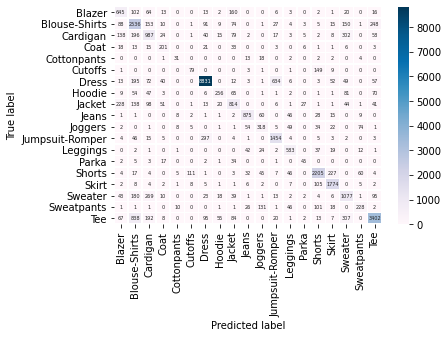

In [69]:
confusion_mat = confusion_mat(Y_pred_list, valY_labels, class_names)
# print(classification_report)

## 17. Conversion to Tensorflow lite

In [70]:
# Tensorflow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open('/home/azure/passion/AI/Final/output/tflite/final.tflite', 'wb').write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpc61mg1uc/assets


102440000